In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
import warnings

warnings.filterwarnings("ignore")

_ = load_dotenv(find_dotenv())

```
docker run \
    -p 7474:7474 -p 7687:7687 \
    -v $PWD/data:/data -v $PWD/plugins:/plugins \
    --name neo4j-apoc \
    -e NEO4J_apoc_export_file_enabled=true \
    -e NEO4J_apoc_import_file_enabled=true \
    -e NEO4J_apoc_import_file_use__neo4j__config=true \
    -e NEO4JLABS_PLUGINS=\[\"apoc\"\] \
    neo4j:latest
```

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0
)

In [4]:
from langchain_neo4j import Neo4jGraph

os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "langchain"

graph = Neo4jGraph(refresh_schema=False)

In [5]:
from langchain_experimental.graph_transformers import LLMGraphTransformer

llm_transformer = LLMGraphTransformer(llm=llm)

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path="../docs/MBA_Worth_It.pdf")

In [7]:
from langchain.text_splitter import CharacterTextSplitter

documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

In [8]:
graph_documents = llm_transformer.convert_to_graph_documents(docs)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='Mba Degree', type='Degree', properties={}), Node(id='Liza Kirkpatrick', type='Person', properties={}), Node(id='Aaron Amat', type='Person', properties={}), Node(id='Getty Images', type='Organization', properties={})]
Relationships:[Relationship(source=Node(id='Liza Kirkpatrick', type='Person', properties={}), target=Node(id='Mba Degree', type='Degree', properties={}), type='AUTHOR', properties={})]


In [9]:
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

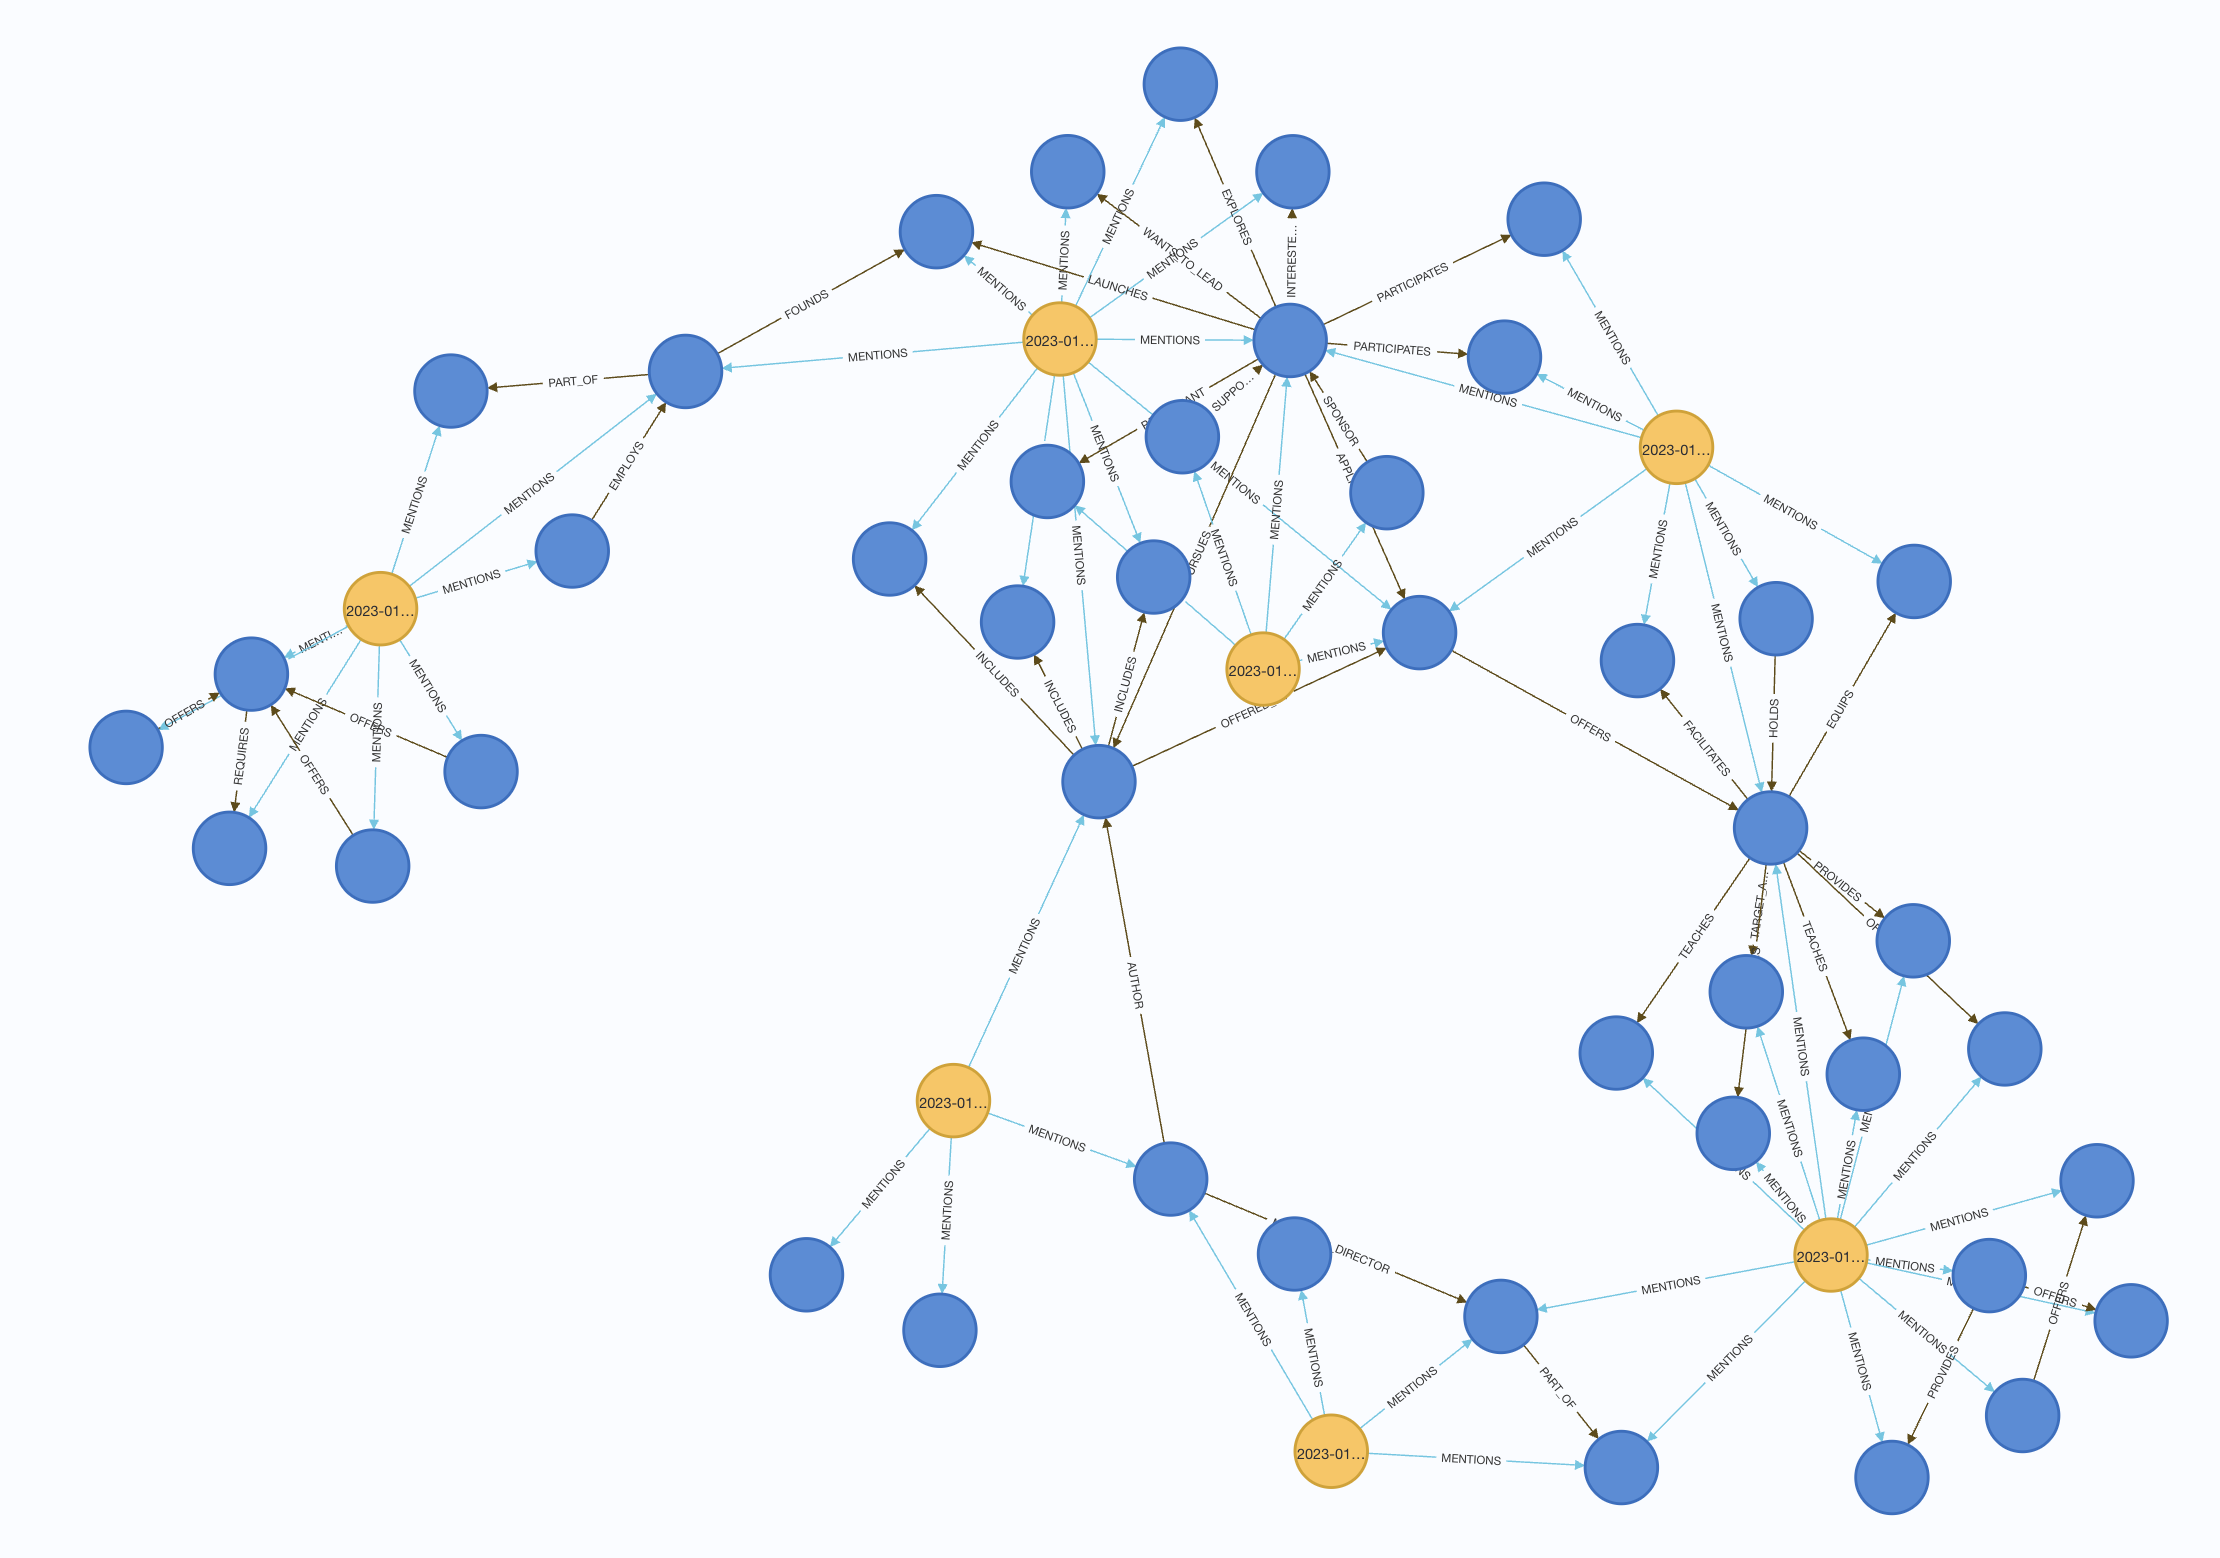

In [10]:
from IPython.display import Image

Image(filename="../images/groq_kg.png")

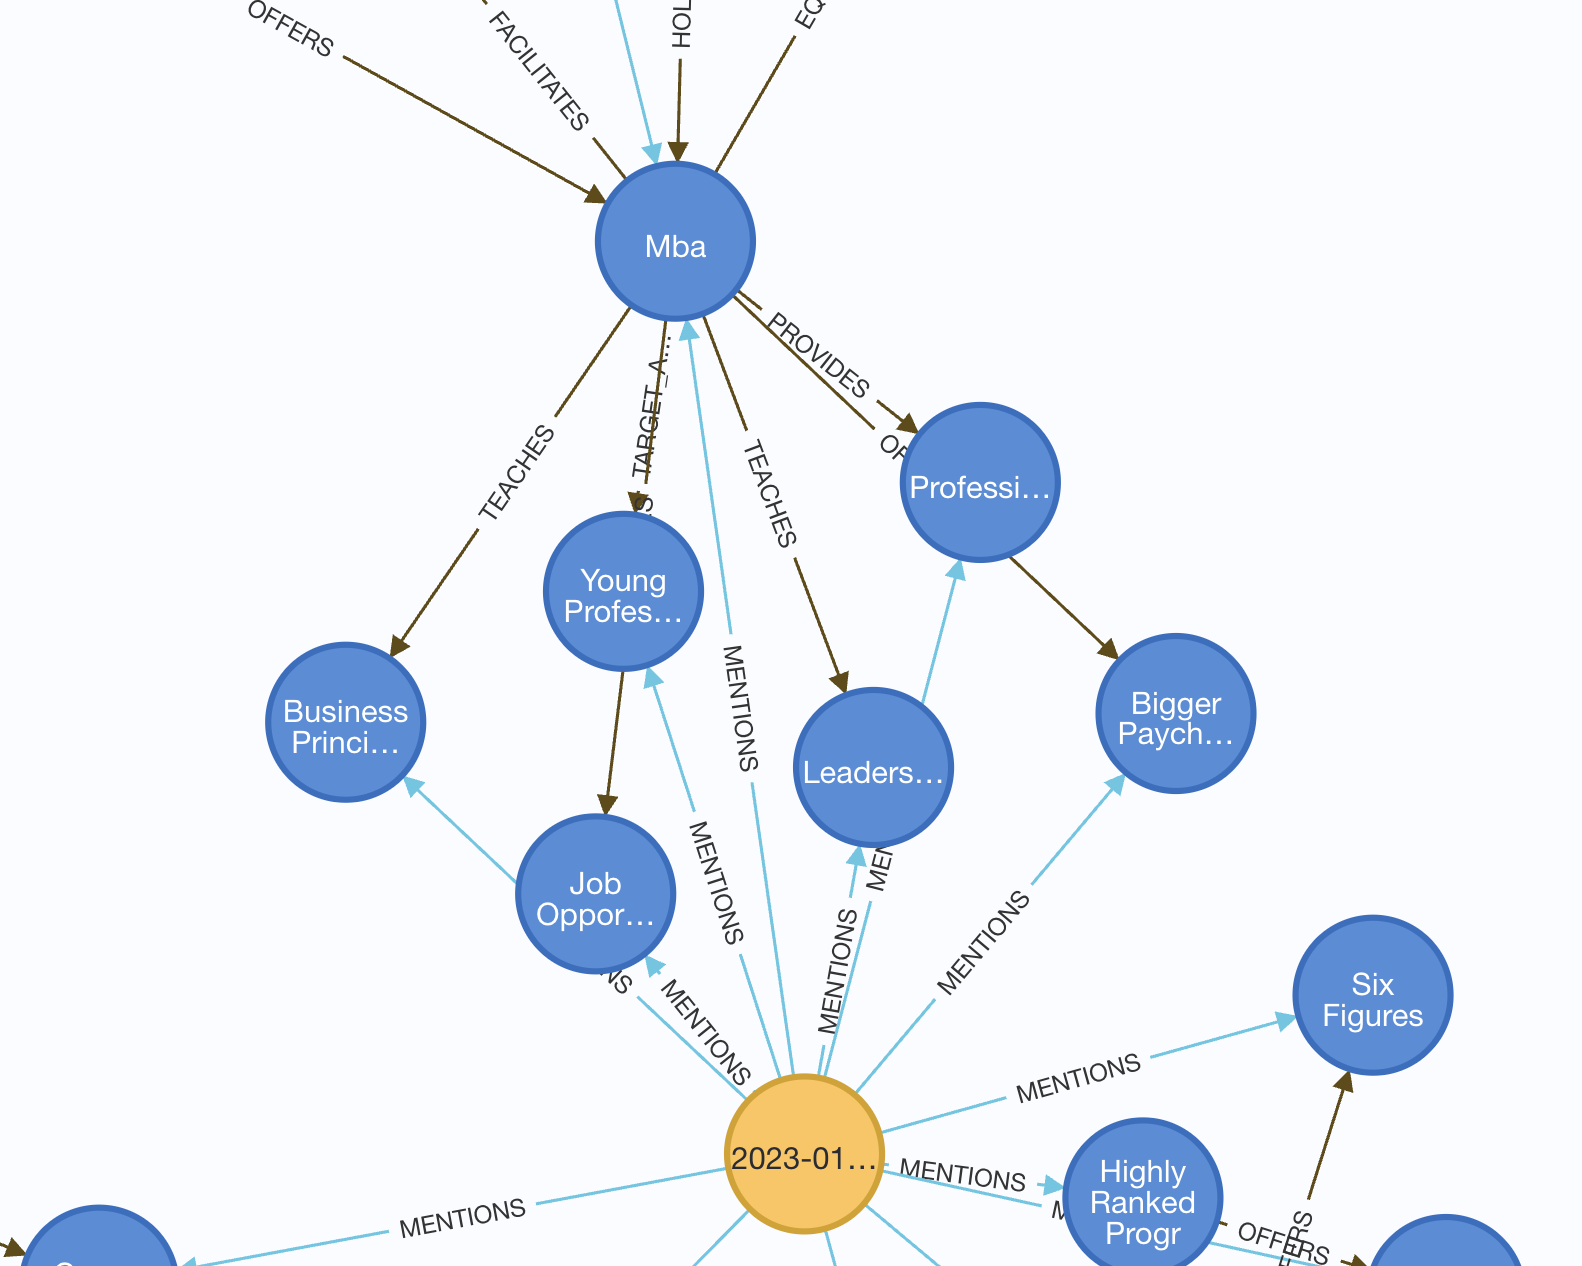

In [11]:
Image(filename="../images/groq_kg_zoom.png")

## Query!

In [12]:
from langchain_neo4j import GraphCypherQAChain

chain = GraphCypherQAChain.from_llm(
    llm, 
    graph=graph, 
    verbose=True, 
    return_intermediate_steps=True,
    allow_dangerous_requests=True
)

In [13]:
response = chain.invoke(
    {"query": "What are the right reasons to get an MBA?"}
)



> Entering new GraphCypherQAChain chain...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: type)} {position: line: 1, column: 18, offset: 17} for query: 'MATCH (n:Reason {type: "MBA"}) RETURN n'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownLabelWarning} {category: UNRECOGNIZED} {title: The provided label is not in the database.} {description: One of the labels in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing label name is: Reason)} {position: line: 1, column: 

Generated Cypher:
MATCH (n:Reason {type: "MBA"}) RETURN n
Full Context:
[]

> Finished chain.


In [14]:
from IPython.display import display, Markdown

display(Markdown(response['result']))

I don't know the answer.

In [15]:
response = chain.invoke(
    {"query": "What are the benefits of an MBA?"}
)

display(Markdown(response['result']))



> Entering new GraphCypherQAChain chain...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: HAS_BENEFIT)} {position: line: 1, column: 17, offset: 16} for query: 'MATCH (n:MBA)-[:HAS_BENEFIT]->(b:Benefit) RETURN b.name'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownLabelWarning} {category: UNRECOGNIZED} {title: The provided label is not in the database.} {description: One of the labels in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing label name

Generated Cypher:
MATCH (n:MBA)-[:HAS_BENEFIT]->(b:Benefit) RETURN b.name
Full Context:
[]

> Finished chain.


I don't know the answer.

## Vector from graph

In [16]:
from langchain_neo4j import Neo4jVector
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="nomic-embed-text")

vector_index = Neo4jVector.from_existing_graph(
    embeddings,
    search_type="hybrid",
    node_label="__Entity__",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)

Extracting entities from text

In [17]:
from pydantic import BaseModel, Field
from typing import List

from langchain_core.prompts import ChatPromptTemplate

class Entities(BaseModel):
    """Identifying information about entities."""

    names: List[str] = Field(
        ...,
        description="All the person, organization, or business entities that appear in the text",
    )

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting organization and person entities from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following"
            "input: {question}",
        ),
    ]
)

entity_chain = prompt | llm.with_structured_output(Entities)

In [18]:
from langchain_neo4j.vectorstores.neo4j_vector import remove_lucene_chars

graph.query("CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (e:__Entity__) ON EACH [e.id]")

def generate_full_text_query(input: str) -> str:
    """
    Generate a full-text search query for a given input string.

    This function constructs a query string suitable for a full-text
    search. It processes the input string by splitting it into words and 
    appending a similarity threshold (~2 changed characters) to each
    word, then combines them using the AND operator. Useful for mapping
    entities from user questions to database values, and allows for some 
    misspelings.
    """
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    print(words)
    for word in words[:-1]:
        print(full_text_query)
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    print(f"Full text query generated: {full_text_query.strip()}")
    return full_text_query.strip()

In [32]:
# Fulltext index query
def structured_retriever(question: str) -> str:
    """
    Collects the neighborhood of entities mentioned
    in the question
    """
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        print("Querying graph...")
        response = graph.query(
            """CALL db.index.fulltext.queryNodes('entity', $query, 
            {limit:2})
            YIELD node,score
            CALL {
              MATCH (node)-[r:!MENTIONS]->(neighbor)
              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS 
              output
              UNION
              MATCH (node)<-[r:!MENTIONS]-(neighbor)
              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS 
              output
            }
            RETURN output LIMIT 50
            """,
            {"query": generate_full_text_query(entity)},
        )
        result += "\n".join([el['output'] for el in response])
        print(f"\n\nresult: {result}")
    return result

def retriever(question: str):
    print(f"Search query: {question}")
    structured_data = structured_retriever(question)
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question, similarity_score_threshold=0.5)]
    final_data = f"""Structured data:
        {structured_data}
        Unstructured data:
        {"#Document ". join(unstructured_data)}
    """
    print(f"\n\n Final data in context: {final_data}")
    return final_data

In [33]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    RunnableParallel(
        {
            "context": retriever,
            "question": RunnablePassthrough(),
        }
    )
    | prompt
    | llm
    | StrOutputParser()
)

In [34]:
response = chain.invoke( "What are the benefits of an MBA?")

Search query: What are the benefits of an MBA?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 4, column: 13, offset: 117} for query: "CALL db.index.fulltext.queryNodes('entity', $query, \n            {limit:2})\n            YIELD node,score\n            CALL {\n              MATCH (node)-[r:!MENTIONS]->(neighbor)\n              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS \n              output\n              UNION\n              MATCH (node)<-[r:!MENTIONS]-(neighbor)\n              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS \n              output\n            }\n            RETURN output LIMIT 50\n            "


Querying graph...
['MBA']
Full text query generated: MBA~2


result: Liza Kirkpatrick - AUTHOR -> Mba Degree
Mba - TARGET_AUDIENCE -> Young Professionals
Mba - TEACHES -> Leadership Skills
Mba - TEACHES -> Business Principles
Mba - PROVIDES -> Professional Network
Mba - PROVIDES -> Job Opportunities
Mba - OFFERS -> Bigger Paycheck
Highly Ranked Programs - PROVIDES -> Seasoned Staff
Highly Ranked Programs - OFFERS -> Significant Pay Bump
Top Schools - OFFERS -> Six Figures
Career Management Center - PART_OF -> Kellogg School Of Management
Mba - EQUIPS -> Future-Ready Skills
Business School - OFFERS -> Mba
Executive - HOLDS -> Mba
Student - PARTICIPATES -> Case Study Competitions
Student - PARTICIPATES -> Group Projects
Mba - FACILITATES -> Networking
Student - PURSUES -> Mba Degree
Student - INTERESTED_IN -> Biopharmaceuticals
Student - WANTS_TO_LEAD -> Organization
Mba Degree - OFFERED_BY -> Business School
Student - EXPLORES -> Entrepreneurial Path
Student - LAUNCHES -> Startup
Alumni

In [35]:
display(Markdown(response))

The benefits of an MBA include:

1. Building leadership skills and learning business principles
2. A stronger professional network
3. Access to job opportunities
4. A bigger paycheck
5. Access to seasoned staff who can help make connections
6. A significant pay bump upon graduation (for those in highly ranked programs)
7. Average salary for graduates from top schools is typically in the six figures
8. Equipping students with future-ready skills
9. Providing a professional network and job opportunities
10. Expanding and diversifying one's professional network through networking events, affinity networks, and student-led conferences.

In [36]:
response = chain.invoke("What are wrong motivations to take an MBA?")
display(Markdown(response))

Search query: What are wrong motivations to take an MBA?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 4, column: 13, offset: 117} for query: "CALL db.index.fulltext.queryNodes('entity', $query, \n            {limit:2})\n            YIELD node,score\n            CALL {\n              MATCH (node)-[r:!MENTIONS]->(neighbor)\n              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS \n              output\n              UNION\n              MATCH (node)<-[r:!MENTIONS]-(neighbor)\n              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS \n              output\n            }\n            RETURN output LIMIT 50\n            "


Querying graph...
['MBA']
Full text query generated: MBA~2


result: Liza Kirkpatrick - AUTHOR -> Mba Degree
Mba - TARGET_AUDIENCE -> Young Professionals
Mba - TEACHES -> Leadership Skills
Mba - TEACHES -> Business Principles
Mba - PROVIDES -> Professional Network
Mba - PROVIDES -> Job Opportunities
Mba - OFFERS -> Bigger Paycheck
Highly Ranked Programs - PROVIDES -> Seasoned Staff
Highly Ranked Programs - OFFERS -> Significant Pay Bump
Top Schools - OFFERS -> Six Figures
Career Management Center - PART_OF -> Kellogg School Of Management
Mba - EQUIPS -> Future-Ready Skills
Business School - OFFERS -> Mba
Executive - HOLDS -> Mba
Student - PARTICIPATES -> Case Study Competitions
Student - PARTICIPATES -> Group Projects
Mba - FACILITATES -> Networking
Student - PURSUES -> Mba Degree
Student - INTERESTED_IN -> Biopharmaceuticals
Student - WANTS_TO_LEAD -> Organization
Mba Degree - OFFERED_BY -> Business School
Student - EXPLORES -> Entrepreneurial Path
Student - LAUNCHES -> Startup
Alumni

According to the text, wrong motivations to take an MBA include:

1. Looking for a "magic pill" or a "golden ticket" that will automatically lead to higher-paying jobs with bigger responsibilities.
2. Applying solely because you want to gain money or power.
3. Applying solely because your parents are willing to pay for it.

The text emphasizes that an MBA requires passion, proactivity, and hard work to expand one's knowledge and skills, and that it's not a guarantee of success. It's essential to have the right motivations, such as honing skills, making a career pivot, accelerating professional development, or expanding one's network, to get the most out of an MBA program.

## Vector embeddings
Regular vector DB search - also using Neo4j

In [24]:
db = Neo4jVector.from_documents(
    docs, 
    embeddings, 
    url=os.environ["NEO4J_URI"], 
    username=os.environ["NEO4J_USERNAME"], 
    password=os.environ["NEO4J_PASSWORD"],
    search_type="hybrid"
)

In [25]:
query= "What are the benefits of an MBA?"
docs_with_score = db.similarity_search_with_score(query, k=2)

In [26]:
docs_with_score

[(Document(metadata={'moddate': '2023-01-14T08:46:45+00:00', 'source': '../docs/MBA_Worth_It.pdf', 'page': 0, 'total_pages': 7, 'producer': 'Skia/PDF m108', 'creationdate': '2023-01-14T08:46:45+00:00', 'page_label': '1', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'}, page_content='B u s i n e s s  E d u c a t i o n\nI s  a n  M B A  D e g r e e  R e a l l y\nW o r t h  I t ?\nb y  L i z a  K i r k p a t r i c k\nD e c e m b e r  0 7 ,  2 0 2 0\nS u m m a r y . \xa0 \xa0 \xa0\nA a r o n A m a t / G e t t y  I m a g e s\nG e t t i n g  a n  M B A  ( M a s t e r  o f  B u si n e s s A d m i n i s t r a t i o n )  t a k e s  a  l o t  o f\nt i m e ,  m o n e y ,  a n d  e f f o r t .  S o  i t ’ s i m p o r t a n t  t o  r e a l l y  t h i n k  a b o u t  w h e t h e r  o r  n o t  i t  i s\nw o r t h  y o u r  w h i l e  t o  p u r su e  o n e .  H e r e  a r e  s o m e  t h i n g s  t o  c o n s i d e r

In [27]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
retriever = db.as_retriever()

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [28]:
response = rag_chain.invoke(query)

display(Markdown(response))

The benefits of an MBA include honing skills like influence, empathy, and building business strategies, helping to make a career pivot, accelerating professional development, and expanding and diversifying one's professional network. An MBA can also provide access to job opportunities and a higher salary, with the average salary for graduates from top schools typically in the six figures. Additionally, an MBA program offers a strong professional network, access to networking events, and a community of future leaders and well-connected alumni.